# Fine-Tuning ESM with SupCon

## Project Overview

In this notebook we will be utilizing Supervised Contrastive Learning to fine-tune the Evolutionary Scale Modeling (ESM) from Meta AI in order to better cluster protein families based on their amino acid sequence. 

There is a lot to unpack in that one sentence so let's start one at a time.

### Supervised Contrastive Learning

Supervised Contrastive Learning (SupCon) is a method of training models to create embeddings that promote alignment. We can think of it as creating a model that creates clusters of embeddings for the given data. The basic premise of this training method is that our loss function pulls embeddings of the same classes together, while pushing the embeddings of different classes apart. We utilize the supervised version of contrastive learning as introduced in *Supervised Contrastive Learning* (Khosla et al., 2020) [paper](https://arxiv.org/abs/2004.11362) since our dataset contains the labels for us to be able to do so. I would suggest reading this paper to build a better intuition of this process and see the math behind it (it is not overly complicated).

### Evolutionary Scale Modeling

The ESM model was developed by Meta AI, specifically the FAIR division, to represent protein sequences as embeddings. Overall, the model could be thought of applying LLM based architecture to the field of biology. We use the smallest version of ESM-2 model with 8 million parameters. You can find the Github repository [here](https://github.com/facebookresearch/esm) and the paper for this research [here](https://www.science.org/doi/abs/10.1126/science.ade2574).

### Biology Crash Course

I am no expert in biology but here is the intuition I've built around the task we are working with. Proteins are the muscle of the cells, they can act: as enzymes and speed up chemical reactions, as receptors that let the cells communicate, as antibodies to protect the organism, and as many other useful things. These proteins are made up of chains of amino acids. The amino acids are just molecules that form together and determine the function of the protein. We can represent these amino acids as letters and proteins as words which naturally lets us utilize transformer architecture. For this project, we want to group them together based on protein families (Pfam). Pfams tell us which proteins are related to each other and therefore serve a similar function. 

Hypothetically, if we develop a model that groups proteins into Pfams, it could be used to predict a protein's purpose and see if it has utility in a clinical setting.

### Dataset 

The dataset we obtain is from [Kaggle](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split?select=random_split). It has about a million different protein sequences with 18,000 different protein families. 



## Importing Libraries

In [29]:
import os
import esm
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, BatchSampler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

## Loading Data

Our dataset is scattered across multiple .csv files so we will handle that with a simple function. 

Later in the notebook we will want to visualize how the different embeddings get clustered together, which kind of doesn't work with 18,000 colors. So we select only the top 50 most prominent classes in our dataset which will help us to visualize and to speed up our training. Feel free to change the numbers and see how that affects the rest of the code.

In [60]:
def load_csv_folder_to_dataset(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        all_data.append(df)
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

train_path = "./train/"

train_data = load_csv_folder_to_dataset(train_path)

NUM_TOP_FAMILIES = 50
top_families = train_data['family_id'].value_counts().nlargest(NUM_TOP_FAMILIES).index
train_data = train_data[train_data['family_id'].isin(top_families)]

print(train_data.shape)
print(train_data.head())

(55216, 5)
           family_id        sequence_name family_accession  \
43              PCRF  D5ANC6_RHOCB/10-198       PF03462.18   
68              IPPT    MIAA_ONYPE/37-265       PF01715.17   
71             HTH_1    Q9F2K8_STRCO/4-63       PF00126.27   
99   Methyltransf_25  Q2S1D8_SALRD/44-141        PF13649.6   
132           MoeA_N   G2IJ98_9SPHN/4-164       PF03453.17   

                                      aligned_sequence  \
43   ITARFEFLEAKL....NTAL......P.PAEIATL...SREY..SD...   
68   QMYQKYDIGTAKITL......EEA.....QGI.........K.......   
71   VRHLECFVAVAEES.HFGRAAT.RLGM...AQPPLSQRIQRLEK.E...   
99   ILDIGCGR.G...R..HA...RA..LV.RR.......G...........   
132  LPVEEAQAR.......LLAMASPL..................PAC....   

                                              sequence  
43   ITARFEFLEAKLNTALPPAEIATLSREYSDLRPVVTEIAAYRQSLD...  
68   QMYQKYDIGTAKITLEEAQGIKHHLLDFLAPGTNYSIYHFQKDARK...  
71   VRHLECFVAVAEESHFGRAATRLGMAQPPLSQRIQRLEKELGVRLF...  
99   ILDIGCGRGRHARALVRRGWQVTGLDLSEDAVAA

Here we will create a dictionary that assigns a label to all of the protein families. 

In [36]:
uniq_ids = sorted(train_data["family_id"].unique().tolist())
label2idx = {fid: i for i, fid in enumerate(uniq_ids)} 

print(label2idx)
print(len(label2idx))

{'AIRS': 1, 'ATP-synt': 3, 'ATP-synt_C': 5, 'Acetyltransf_7': 7, 'Ala_racemase_C': 9, 'Ank': 11, 'B5': 13, 'Bac_transf': 15, 'CPSase_L_D3': 17, 'Chromate_transp': 19, 'DHH': 21, 'DNA_binding_1': 23, 'DUF2179': 25, 'DnaJ_C': 27, 'DnaJ_CXXCXGXG': 29, 'FMN_bind': 31, 'Fer2_2': 33, 'Flavokinase': 35, 'GARS_C': 37, 'GIDA_assoc': 39, 'Glyco_trans_1_4': 41, 'Glyco_transf_4': 43, 'Glycos_trans_3N': 45, 'HTH_1': 47, 'Ham1p_like': 49, 'His_kinase': 51, 'IPPT': 53, 'LRR_1': 55, 'Lipase_GDSL_2': 57, 'Lum_binding': 59, 'Maf': 61, 'Methyltransf_25': 63, 'MgtE': 65, 'MoeA_N': 67, 'MutS_III': 69, 'OTCace_N': 71, 'P5CR_dimer': 73, 'PCRF': 75, 'PEP-utilizers': 77, 'PTS-HPr': 79, 'Pept_tRNA_hydro': 81, 'PmbA_TldD': 83, 'Prenyltransf': 85, 'RF-1': 87, 'SRP54_N': 89, 'THF_DHG_CYH': 91, 'TrmE_N': 93, 'UPF0126': 95, 'WD40': 97, 'gag_pre-integrs': 99}
50


## Creating Dataset and Dataloader
Now we define our dataset class.

In [37]:
class PfamDataset(Dataset):
    def __init__(self, df, label2idx):
        self.seqs = df["sequence"].astype(str).str.upper().tolist()
        self.labels = [label2idx[fid] for fid in df["family_id"]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.seqs[idx], self.labels[idx]

train_dataset = PfamDataset(train_data, label2idx)

As with most string-based models we need to tokenize our inputs. Luckily, the ESM code provides us with a helpful class that allows us to tokenize each batch. Below we implement a collate function that makes sure to convert the batches of raw sequences into the tokens that our model can utilize. 

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()          # model and esm helper function that can tokenize sequences
model = model.to(device)
model.eval()
batch_converter = alphabet.get_batch_converter()       

def collate_fn(batch):
    seqs, labels = zip(*batch)              
    names = [f"seq{i}" for i in range(len(seqs))]  # the batch_converter uses (name,seq) format

    _, _, tokens = batch_converter(list(zip(names, seqs)))  
    labels = torch.tensor(labels, dtype=torch.long)

    return {"tokens": tokens, "labels": labels}


There is another nuance that we need to address. The SupCon loss chooses an anchor out of the batch and then uses a positive example, a sample with the same label, to adjust the embeddings. If we simply do random sampling for each batch then we might have a batch that only contains one sample of a particular class, making our training useless when that sample is selected as the anchor. 

To avoid this issue we implement a custom BatchSampler class that ensures we always have at least 2 samples per class. We do this by picking some amount of random classes and for each of those random classes we pick samples from that class. Our batch size will be equivalent to `class_per_batch * samples_per_class`. 

In [ ]:
class ClassBalancedBatchSampler(BatchSampler):
    def __init__(self, labels, classes_per_batch=7, samples_per_class=2, drop_last=True):
        self.labels = [int(l) for l in labels]
        self.c = classes_per_batch
        self.p = samples_per_class
        self.drop_last = drop_last

        self.index_by_class = {}
        for idx, y in enumerate(self.labels):
            self.index_by_class.setdefault(y, []).append(idx)

        self.classes = [cls for cls, idxs in self.index_by_class.items() if len(idxs) >= self.p] # not super necessary, but we only consider classes with at least p samples
        total = sum(len(v) for v in self.index_by_class.values())
        self._len = max(0, total // (self.c * self.p))

    def __iter__(self):
        pools = {cls: idxs.copy() for cls, idxs in self.index_by_class.items()}
        for idxs in pools.values():
            random.shuffle(idxs)

        for _ in range(self._len):
            chosen = random.sample(self.classes, min(self.c, len(self.classes)))
            batch = []
            for cls in chosen:
                pool = pools[cls]
                if len(pool) < self.p:
                    pool[:] = self.index_by_class[cls].copy()
                    random.shuffle(pool)
                take = min(self.p, len(pool))
                batch.extend([pool.pop() for _ in range(take)])
            if len(batch) == self.c * self.p:
                yield batch
            elif not self.drop_last and len(batch) > 0:
                yield batch

    def __len__(self):
        return self._len

I elected for each batch to have all the classes and 2 samples. Increasing the `samples_per_class` made the training significantly longer, even with fewer classes in the batch. 

In [40]:
sampler = ClassBalancedBatchSampler(train_dataset.labels, classes_per_batch=50, samples_per_class=2)
train_dataloader = DataLoader(train_dataset, batch_sampler=sampler, collate_fn=collate_fn)

## Checking the Baseline

After setting up our `DataLoader` class we can move on to seeing how the baseline model performs at clustering the data. We will do this in two ways: visually through a t-SNE plot and computationally by training a KNN model.

First, we will need to extract the embeddings of our data from the model. I wrote a function that lets us do just that as well as specify how many of the samples we actually want to embed (our dataset has 55,000 samples and embedding them all can take some time). I ran this function for 10,000 samples and saved the embeddings in a .pkl file.

In [41]:
def get_embeddings(dataloader, model, alphabet, layer=6, max_items=1000, device="cpu"):
    model.eval()

    embs = []
    tensor_labels = []
    seen = 0
    with torch.no_grad():
        for batch in dataloader:
            tokens = batch["tokens"].to(device)          
            labels = batch["labels"].to(device)
            out = model(tokens, repr_layers=[layer], return_contacts=False)
            tok_repr = out["representations"][layer]     

            pad = alphabet.padding_idx
            lens = (tokens != pad).sum(1)                
            seq_embs = torch.stack([
                tok_repr[i, 1:L-1].mean(0) for i, L in enumerate(lens)
            ])                                           

            seq_embs = torch.nn.functional.normalize(seq_embs, dim=1)

            embs.append(seq_embs.cpu())                  
            tensor_labels.append(labels.cpu())
            seen += seq_embs.size(0)
            if seen >= max_items:
                break

    return torch.cat(embs, dim=0), torch.cat(tensor_labels, dim=0) 

""" UNCOMMENT TO GET EMBEDDINGS

train_embs, train_labels = get_embeddings(train_dataloader, model, alphabet, max_items=10000, device=device)
embs_and_labels = (train_embs, train_labels)

with open("train_embs.pkl", "wb") as f:
    pickle.dump(embs_and_labels, f)
""" 

with open("train_embs.pkl", "rb") as f:
    train_embs, train_labels = pickle.load(f)

print(train_embs.shape)

torch.Size([10016, 320])


The embeddings are ready! Note that the embedding size for the 8M model is 320, which is reflect in the size of our tensor. The extra 16 samples come from how we wrote the termination condition, not super important.

We will now visualize the model's clustering abilities by using t-SNE, a visualization technique for high-dimensional data. The idea behind t-SNE is to preserve neighborhoods of data in high dimensions on a 2 dimensional plane. It does so by turning distances into probabilities and sampling from a Student-t distribution. There are various parameters involved in this, the most important one being perplexity which controls how tight the neighborhoods are on the graph (the higher the more compact the clusters will be).

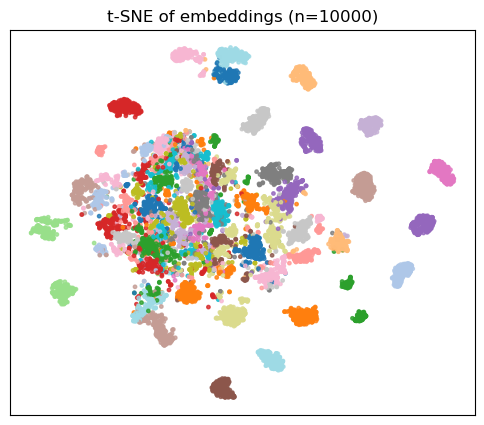

In [32]:
def run_tsne(embs, labels=None, n_samples=1000, random_state=42, title="t-SNE of embeddings"):
    X = embs.detach().cpu().numpy() if hasattr(embs, "detach") else np.asarray(embs)
    y = labels.detach().cpu().numpy() if (labels is not None and hasattr(labels, "detach")) else (
        np.asarray(labels) if labels is not None else None
    )

    N = X.shape[0]
    if N > n_samples:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N, size=n_samples, replace=False)
        X = X[idx]
        y = y[idx] if y is not None else None

    pca_k = min(50, X.shape[1])  
    X_pca = PCA(n_components=pca_k, random_state=random_state).fit_transform(X)

    tsne = TSNE(
        n_components=2,
        perplexity=50,         
        learning_rate=200,
        init='pca',
        max_iter=1000,
        random_state=random_state,
        verbose=0,
    )
    X_2d = tsne.fit_transform(X_pca)

    plt.figure(figsize=(6,5))
    if y is not None:
        plt.scatter(X_2d[:,0], X_2d[:,1], s=6, c=y, cmap="tab20", alpha=0.8)
    else:
        plt.scatter(X_2d[:,0], X_2d[:,1], s=6, alpha=0.8)
    plt.xticks([]); plt.yticks([])
    plt.title(f"{title} (n={X_pca.shape[0]})")
    plt.show()

    return X_2d

X2d = run_tsne(train_embs, labels=train_labels, n_samples=10000, random_state=123)

Based on this visualization of the base model we can see that it has solid capabilities in separating the data based on the protein sequences. There are several distinct clusters that have no overlap, and then there is a messy collection of clusters in the middle that do have significant overlap. Our goal will be to make it so that all the clusters will be as separate as possible.

While the visual is telling we do want to measure this "clustering ability" more concretely. To do so we will train a simple KNN model and evaluate its performance. The F1 score is there to adjust for any class imbalances, though it shouldn't make much of a difference for our selected data.

In [54]:
knn = KNeighborsClassifier(n_neighbors=NUM_TOP_FAMILIES)  
knn.fit(train_embs, train_labels)

train_preds = knn.predict(train_embs)
accuracy = accuracy_score(train_labels, train_preds)
f1 = f1_score(train_labels, train_preds, average="weighted")  

print(f"KNN Accuracy: {accuracy}")
print(f"KNN F1 Score: {f1}")

KNN Accuracy: 0.9193290734824281
KNN F1 Score: 0.9209609232296961


Now that our baseline scores and visual are done we can move on to fine-tuning the model!

## Fine-Tuning

To fine-tune the model we will create a projection head that takes the current embeddings of the base ESM model and projects them into new ones which aim to be better for clustering the data. For the projection head a simple FNN is often the default, and so that's what we will define.

In [47]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.net(x)
        x = nn.functional.normalize(x, dim=-1)
        return x

Here we will define our training loop. We import the loss function from the SupCon paper, the original code can be found [here](https://github.com/HobbitLong/SupContrast/tree/master). The API to calculating the loss requires a bit of tinkering with tensor dimensions, but otherwise it is pretty straight forward. 

In [48]:
from SupConLoss import SupConLoss

def train_contrastive_model(model, alphabet, projection_head, dataloader, num_epochs=10, learning_rate=1e-3):
    model.eval()  # freeze the pre-trained model
    projection_head.train()

    optimizer = optim.Adam(projection_head.parameters(), lr=learning_rate)
    criterion = SupConLoss()


    counter = 1
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in dataloader:
            tokens = batch["tokens"].to(device)
            labels = batch["labels"].to(device)
            print(counter / len(dataloader))
            counter += 1
            # my get_embeddings function wouldn't work here because it also iterates over dataloader
            with torch.no_grad():
                out = model(tokens, repr_layers=[6], return_contacts=False)
                tok_repr = out["representations"][6]
                pad = alphabet.padding_idx
                lens = (tokens != pad).sum(1)
                seq_embs = torch.stack([tok_repr[i, 1:L-1].mean(0) for i, L in enumerate(lens)])
                seq_embs = torch.nn.functional.normalize(seq_embs, dim=1)

            projections = projection_head(seq_embs)
            projections = projections.unsqueeze(1)
            loss = criterion(projections, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # save checkpoint every epoch
        torch.save(projection_head.state_dict(), f"projection_head_epoch{epoch+1}.pth")

    return loss_history

I'll comment out the code I used to train the model and import the saved weights.

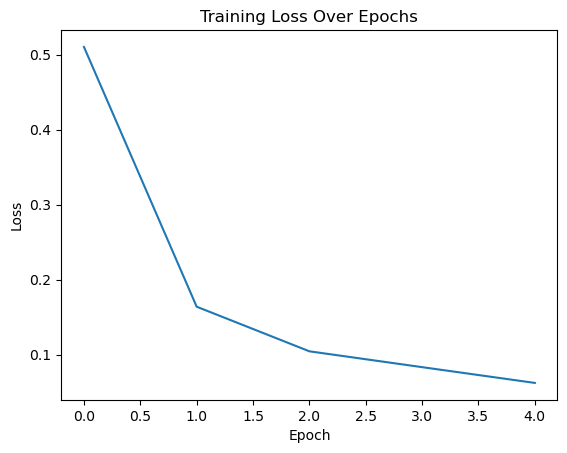

In [53]:
projection_head = ProjectionHead(320).to(device)

""" UNCOMMENT TO TRAIN THE MODEL

loss_history = train_contrastive_model(model, alphabet, projection_head, train_dataloader, num_epochs=5, learning_rate=1e-3)
torch.save(projection_head.state_dict(), "projection_head.pth")

with open("loss_history.pkl", "wb") as f:
    pickle.dump(loss_history, f)
""" 

with open("loss_history.pkl", "rb") as f:
    loss_history = pickle.load(f)

projection_head.load_state_dict(torch.load("projection_head.pth", map_location=device))
projection_head.eval()

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

Finally, we get to evaluate the performance of our model.

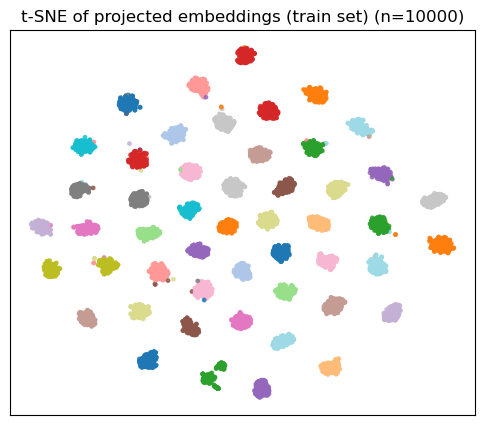

In [58]:
model.eval(); projection_head.eval()
proj_embs_list, proj_labels_list = [], []

with torch.no_grad():
    for batch in train_dataloader:
        tokens = batch['tokens'].to(device)
        labels = batch['labels'].to(device)

        out = model(tokens, repr_layers=[6], return_contacts=False)
        tok_repr = out['representations'][6]

        pad = alphabet.padding_idx
        lens = (tokens != pad).sum(1)

        seq_embs = torch.stack([tok_repr[i, 1:L-1].mean(0) for i, L in enumerate(lens)])
        seq_embs = torch.nn.functional.normalize(seq_embs, dim=1)
        proj = projection_head(seq_embs)  

        proj_embs_list.append(proj.cpu())
        proj_labels_list.append(labels.cpu())

proj_embs = torch.cat(proj_embs_list)
proj_labels = torch.cat(proj_labels_list)

_ = run_tsne(proj_embs, labels=proj_labels, n_samples=10000, random_state=123, title='t-SNE of projected embeddings (train set)')

Success! This is clearly a much better result than we had before. Visually we can see that the model separates the clusters incredibly well. There are a couple of misfit points in there but overall the projection head seemed to be very effective. Let's see how the KNN scores will fair.

In [59]:
knn = KNeighborsClassifier(n_neighbors=NUM_TOP_FAMILIES)  
knn.fit(proj_embs, proj_labels)

train_preds = knn.predict(proj_embs)
accuracy = accuracy_score(proj_labels, train_preds)
f1 = f1_score(proj_labels, train_preds, average="weighted")  

print(f"KNN Accuracy: {accuracy}")
print(f"KNN F1 Score: {f1}")

KNN Accuracy: 0.9963949275362319
KNN F1 Score: 0.9963967175030819


As expected, a significant improvement over the 92% we got for the base line model.

## Conclusion

Using the SupCon loss we were able to fine-tune the 8M parameter ESM-2 model to have better embedding alignment. We make this conclusion based on the 7% improvement on KNN models' performances on clustering the data using the base model's embeddings and then our fine-tuned ones. In addition, the visual graphs using t-SNE support our results. 